# Notes on Neural Network Classification by Joseph Nahmias <<joe@nahmias.net>>
### Based on the [Machine Learning class](https://www.coursera.org/learn/machine-learning/) by Andrew Ng on Coursera -- Weeks 4 & 5
This work is licensed under a <a rel="license"
href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons
Attribution-ShareAlike 4.0 International License</a>.
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img
alt="Creative Commons License" style="float:right; border-width:0"
src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>

## 1 What is a neural network and why do we need one?
### 1.1 Complex problems lead to many features
Many classification problems involve data with a large number features.

For example, to do a decent job of predicting the price of a house you'd naturally want to include features such as: the location at various granularities from the state down to the block it's on; details about the unit including number of bathrooms, bedrooms, the size of each, the layout, other amenities; facts about the structure, which way it faces, how much light it gets, when it was built, type of construction, when it was last renovated, etc.  It's easy to see that it wouldn't take much to end up with a list of over 100 relevant features.

In a more complex problem space like healthcare, the number of features is much bigger. For instance, the system of disease classification in the USA is known as [ICD-10-CM has about 72 thousand](https://www.cdc.gov/nchs/icd/icd10cm.htm) individual codes, while [SNOMED CT has about 350k](https://www.snomed.org/snomed-ct/five-step-briefing).  The list of hospital medical procedures known as [ICD-10-PCS has over 78k codes](https://www.cms.gov/Medicare/Coding/ICD10/2019-ICD-10-PCS.html); the [HCPCS Level II codeset](https://www.cms.gov/Medicare/Coding/HCPCSReleaseCodeSets) of procedures has about 17k, which includes the [AMA's CPT](https://www.ama-assn.org/practice-management/cpt/cpt-overview-and-code-approval) (about 12k) and the [ADA's CDT](https://www.ada.org/en/publications/cdt) (about 700).  Laboratory tests coded in a system called [LOINC](https://loinc.org/) number over 90k in v2.66.  Then you look at the number of drugs & pharmaceuticals available, which are classified under a system called [RxNORM from the US NLM](https://www.nlm.nih.gov/research/umls/rxnorm/) has over 1 million.  The [Genomic Reference Consortium](https://www.ncbi.nlm.nih.gov/grc/data) lists about 3 billion base-pairs in the human genome. Not all of these would be used in a given model; but, when you consider all this, plus social, environmental, family, and other health factors it's easy to reach over 1 million features in a model for a prediction of a person's health.

If you think that's a lot of features, let's discuss called computer vision -- the task of teaching a computer to see and recognize objects the way our eyes do.  Consider that a typical HD picture consists of a grid of 1920 × 1080 ≈ 2M pixels.  Each of these pixels has not only a brightness/intensity, but also color information.  Furthermore, many applications call for much better cameras than that -- and sometimes dozens of them!  So, even with compression and other techniques, designing a model with over 10 million features is not unimaginable.

### 1.2 More complex features are needed to make sophisticated predicitons
Even when we keep the number of features small, tools like linear regression
or [logistic classification](Multi-Class_Logistic_Classification.ipynb)
can only generate simple models.
This limitation is inherent to those techniques because they are only able to
make coarse distinctions in the values of a feature.

For example, in the two feature dataset below, we want to build a classification
model that can distinguish between the blue cross (positive) and red circle
(negative) classes.
We train a standard logistic classification model on this data, yielding
$ θ_{min} = [-0.575, 0, 0] $, which equates to the hypothesis:

$$ h_θ(x) = g(θ^Tx) = g(-0.575x_0 + 0x_1 + 0x_2) = g(-0.575) = 0.36 $$

This hypothesis is a constant false value, equal to the proportional of positive
cases in the training set (36/100); it makes no use of the input features whatsoever!
Consequentially, it returns a prediction of 0 for all inputs; and when run against
the original training dataset every positive datapoint is misclassified.

More data or more interations in training will not improve this; rather, we need
new higher-order features (based on the existing ones) to use in our model in order
to correctly classify this data, as approximated by the green line below.

Iteration    94 | Cost: 6.534182e-01
t_min =

  -5.7536e-01   1.1154e-13   1.1627e-13

h =  0.36000


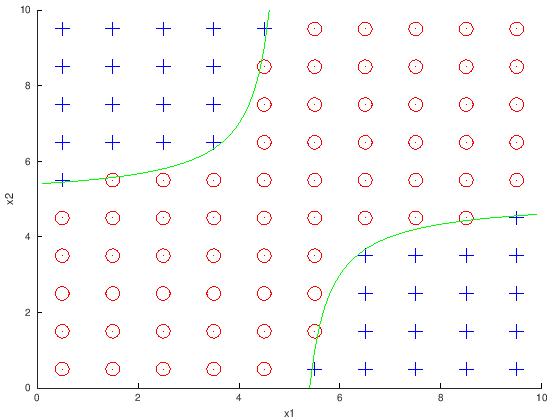

In [1]:
r = [0.5:9.5] .* ones(10);
X = [r(:) r'(:)];
Y = str2double(vec(dec2bin([31 15 15 15 1 512 960 960 960 992],10)));
function [Cost,grad] = logClassCostGrad(theta,X,y)
  h = 1.0 ./ ( 1.0 + exp(-X*theta) );
  Cost = ( -y'*log(h) -(1-y')*log(1-h) ) / size(X,1);
  grad = vec(X'*(h-y)./size(X,1));
endfunction
J = @(t) logClassCostGrad(t, [ones(size(X,1),1) X], Y);
options = optimset('GradObj', 'on', 'MaxIter', 150);
t_min = fmincg(J, zeros(size(X,2)+1,1), options)'
h = 1 / (1+exp(-1*t_min(1)))
hold on; xlabel("x1"); ylabel("x2"); axis([0 10 0 10]);
set(gca(),"defaultlinemarkersize",13);
plot(X(Y==0,1),X(Y==0,2),"or", X(Y==1,1),X(Y==1,2),"+b");
v = [0.1:0.1:9.9];
plot(v, 5 + 2 ./ (5-v),"-g")

### 1.3 Higher-order features add up quickly

Including these higher-order features, however, makes the model grow rapidly.
The formula for the number of features used to add an additional power of
the original features is given by:

$$\binom{d+n-1}{n-1} = \frac{(d+n-1)!}{d!(n-1)!}$$

where n is the number of (original) features in the model,
and d is the [multinomial](https://en.wikipedia.org/wiki/Multinomial_theorem)
degree to be added.
Here is a table of the number of features added by introducing the first few
powers of model features:

Original | $2^{nd}$ Order | $3^{rd}$ Order | $4^{th}$ Order |
----|----|----|----
      5 |       15 |       35 |        70
     10 |       55 |      220 |       715
     15 |      120 |      680 |     3,060
     25 |      325 |    2,925 |    20,475
     35 |      630 |    7,770 |    73,815
     50 |    1,275 |   22,100 |   292,825
     65 |    2,145 |   47,905 |   814,385
     80 |    3,240 |   88,560 | 1,837,620
     99 |    4,950 |  166,650 | 4,249,575
     
From this table we can clearly see how fast the number of features rises
-- even when starting with less than 100 features and keeping the degree low!

### 1.4 We need a new way of learning

By this point, it's quite clear that we need a different model for machine
learning that can handle a large number of design features with higher-order
combinations without collapsing under its own weight.
In the 1960s and 70s, scientists were fascinated with the way the human brain
worked and how its functions like hearing or seeing, despite normally being
located in a particular region of the brain, seemingly could be successfully
performed in any part of the brain at need (eg. severe trauma).
This effect, called [Neuroplasticity](https://en.wikipedia.org/wiki/Neuroplasticity),
led to what they called the *one learning algorithm* hypothesis,
or [Hebbian Theory](https://en.wikipedia.org/wiki/Hebbian_theory), which
states that the brain learns all skills by the use of the exact same technique --
the repeated activation of a neuron by the neurons connected to it.

As a result, in the 1980s, AI researchers tried to replicate the way that the
human brain functions in order to produce a system that would be generic
enough for any machine learning application.
They did this by modeling the design of the biological neurons in the brain
as a network of comptational nodes that exchanged information with each other.
They called this a **neural network**.
Recent advances in computational speed, parallel processing, and cloud
computing have resurrected the neural network paradigm -- making it one
of the state-of-the-art machine learning techniques used in current
day applications.

## 2 (Artificial) Neural networks

An artificial neural network is a parallel distributed processing system
based on the [Connectionist](https://en.wikipedia.org/wiki/Connectionism)
understanding of how the human brain learns new information.
There are three main parts to this system:
1. Nodes
2. (Inter-)Connections
3. Architecture


### 2.1 Nodes

Each node corresponds to an individual neuron in the human brain and
represents a feature given by a simple computational unit.
It has an activation function which is generally non-linear and is used
to compute an output from the inputs presented to the node.
Some examples are:
1. Hyperbolic Tangent
2. Logistic
3. [Rectified Linear](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
4. [Swish](https://arxiv.org/abs/1710.05941)

### 2.2 Connections

The connections in an artificial neural network model the [synapses](
https://en.wikipedia.org/wiki/Synapse) in the human brain which convey
information from one neuron to another.
This is represented by passing the output of one node in the network to
the input of another node in the network, weighted by an appropriate
coefficient.
An individual node can have many input connections; the impact that each
one has on the output of the node is determined by the weight (or
coefficient).
Likewise, the output of the node can be transmitted by multiple connections
to different nodes, again with varying weights as needed.

Although, in general, you can design a neural network where the connections
form a loop such that the input of a node is (indirectly) derived from its
output, for our purpose here we will restrict ourselves to networks that
have no cycles of this sort such that the calculations / information / data
flow in a single direction within the network.
While this is not an ideal model of learning in the human brain, according
to current theory, it is vastly simpler and adequate for many applications
due to the [Universal Approximation Theorem](
https://en.wikipedia.org/wiki/Universal_approximation_theorem) which has
been proven to show that simple Neural Networks can provide arbitrarily
good approximations of many classes of functions.


### 2.3 Architecture

In our architecture, known as a [Feedforward neural network](
https://en.wikipedia.org/wiki/Feedforward_neural_network),
we arrange the nodes into groups called **layers**.
Each node within a layer accepts the output from the prior layer
as its input, computes the value of its activation function,
and then transmits its output to the nodes in the next layer.

The first layer consists of just the raw input features from the data.
The last layer is the output of the network, which should correspond
to the model or problem we are trying to solve or predict.
Each layer between them is called a **hidden layer** because it does
not have an easily described purpose; rather its goal is derived
iteratively as the network is trained.

There are many ways to set up how the different layers talk to each
other; here we will use a design called a **Fully-Connected Neural Network**
which follows these rules:
1. Each node will use the logistic activation function $g(z)=\frac{1}{1+e^{-z}}$.
1. The outputs of each node in layer **_i_** (collectively, the vector
$a^{(i)}$) are fed to every node of the following layer (**_i+1_**).
2. These connections are governed by a set of parameters called
**weights** that are given by the matrix $Θ^{(i)}$.
3. In addition, each layer (except the output) has as its first node
a **bias node** that takes no input, but always outputs 1, with
corresponding weights for each connection to the nodes of the
following layer.

Below is a diagram of a generic fully-connected NN.  In it, each
layer is denoted with a different color starting with the yellow
input layer, through the blue output layer.  Also, each layer
(except the output) has its bias node at the top in a slightly
lighter shade.  At the bottom, is the notation for the output of
the nodes of each layer and the weights for the connections
between the layers.

In [2]:
%run --language html fcnn.svg

## 3 Some basic neural networks
Now that we have a basic understanding of the parts of a
neural network, we will take a look at some simple ones
to see how they work in greater detail.

### 3.1 A very simple Neural Network
The first NN we will examine is pictured below.  It has a
single input feature ($x_1$), a bias node ($x_0$, shown as
simply +1), no hidden nodes, and one output node (in blue).
There are connections between both the input and bias nodes
and the output node.  The weights for each of those
connections are show on the diagram.

In [3]:
%run --language dotMJ bool_NOT.gv

The way it works is as follows:
1. The network receives an input of either 0 or 1 as $x_1$.
2. The input and bias nodes are multiplied by the connection
weights and fed as input to the output node.
3. The output node computes the activation function on its
inputs and sends that value as the result for the network.

Let's work through the first case:
1. If the input is 0, $x_1 = 0$.
2. The input for the next node ($z_1$) is calculated as: $z_1 =
x_0\cdot10 + x_1\cdot-20 = +1\cdot10 + 0\cdot-20 = 10$.
3. The activation function is calculated as: $a_1 = σ(z_1) =
σ(10) \approx 1$, where $σ$ is the logistic function.

In the second case:
1. The input is 1, so $x_1 = 1$.
2. $z_1$ is then calculated as: $z_1 = x_0\cdot10 + x_1\cdot-20
= +1\cdot10 + 1\cdot-20 = 10 - 20 = -10$.
3. The activation function then: $a_1 = σ(z_1) = σ(-10) \approx
-1$, again with $σ$ as the logistic function.

Here's a short table summarizing the behavior of this neural network:

Input | $x_1$ | $z_1$ | $a_1$ | Output
------|-------|-------|-------|-------
  0   |   0   |   10  |   1   |   1
  1   |   1   |  -10  |   0   |   0

So we see that this network just flips (or inverts) it's
input -- when it receives 0 it sends 1, and vice-versa.

**Note**: *The symbol in front of $x_1$ in the diagram output
[$\neg$] is the sign for negation in boolean logic.*

### 3.2 More boolean logic
The next Neural Network we will examine is slightly more complex,
it has the same single output and no hidden layer, but now has two
inputs and a bias with corresponding weights.  Here is a diagram:

In [4]:
%run --language dotMJ bool_NAND.gv

Let's determine what it does using a similar analysis as above,
except in step 2 we compute $z_1$ as: $z_1 = Θ^{(1)}_0 \cdot
x_0 + Θ^{(1)}_1 \cdot x_1 + Θ^{(1)}_2 \cdot x_2$.
Like the previous example, we have the bias node ($x_0$) set to +1,
but here we have two input features $x_1, x_2$ either of which can
be 0 or 1. The weights of the connections between the input and
output layers, $Θ^{(1)}$, are shown in the diagram.  If we think of
Θ as a vector or matrix, then Θ = {30, -20, -20}.

Carrying out the calculations, we get the following table:

$x_1$ | $x_2$ | $z_1$ | $a_1$ 
------|-------|-------|-------
  0   |   0   |   30  |   1
  0   |   1   |   10  |   1
  1   |   0   |   10  |   1
  1   |   1   |  -10  |   0

Here we see that the network outputs 1 except when both inputs
are set to 1, in which case it outputs 0; this behavior corresponds
to the boolean NAND function. This is an important result because NAND
is one of the universal logic gates and is a [functionally complete](
https://en.wikipedia.org/wiki/Functional_completeness) boolean operator,
which means that any arbitrary boolean function can be constructed by
combining multiple NAND gates &mdash; and hence be designed by an
appropriate usage of a Neural Network.

**Note**: *The up-arrow symbol in the diagram output [$\uparrow$],
used to denote the NAND boolean function, is known as the
[Sheffer stroke](https://en.wikipedia.org/wiki/Sheffer_stroke).*

### 3.3 A three-layer Neural Network
The final hand-crafted Neural Network that we will analyze in this very detailed way introduces a third layer of nodes, between the input and output layers, called a hidden layer. Here we have only one hidden layer, but more complex NNs can have multiple (see diagram above). These hidden layers are where the real power of these systems lies &mdash; they represent the higher-order features that we were looking for way back in the beginning of this topic.

In [5]:
%run --language dotMJ bool_XOR.gv

We can seek to understand what this does in two different ways:
1. We can break it down and analyze each node individually to
 determine its function.
2. We can "blindly" carry out the calculations for all possible
 input value combinations, compare the inputs to the outputs,
 and see if we can generalize the behavior observed.

Since this is the last small, hand-crafted network we will see,
we'll start with method #1, as we did above. After that, we will
also look at #2 as that will be the key to working with larger
and more complex systems.

#### 3.3.1 Three-layer NN analysis, part 1
We'll start our analysis at the end and work our way backwards:
* Looking at $a^{(2)}_1$, we can easily tell that it will be 1
 whenever either $a^{(1)}_1$ or $a^{(1)}_2$ (or both) are 1;
 thus, in terms of boolean logic, we have
 $a^{(2)}_1 = a^{(1)}_1 \lor a^{(1)}_2$,
 where $\lor$ is the OR function.
* Moving to the hidden layer, starting with $a^{(1)}_1$ we see
 that for it to end up as 1, $x_1$ must be 1 and $x_2$ must be 0;
 in boolean terms: $a^{(1)}_1 = x_1 \land \lnot x_2$,
 where $\land$ is the AND function.
* On the other hand, $a^{(1)}_2$ is the reverse &mdash; $x_1$ must
 be 0 and $x_2$ must be 1; giving the formula:
 $a^{(1)}_1 = \lnot x_1 \land x_2$.

Putting it all together, substituting for the hidden nodes, we get:

$$ a^{(2)}_1 = (x_1 \land \lnot x_2) \lor (\lnot x_1 \land x_2) = \boxed{x_1 \oplus x_2} $$

where $\oplus$ represents the XOR boolean function.